# Property potential energy surfaces

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['font.size'] = 12

from qa_tools.utils import *
from qa_tools.prediction import *
from qa_tools.data import prepare_dfs
from qa_tools.analysis import *

json_path = '../../json-data/atom-pyscf.qa-data.posthf.json'
df_qc, df_qats = prepare_dfs(json_path, get_CBS=False)

## Alchemical PES system specifications

In [2]:
n_electrons = 16
excitation_level = 0

basis_set = 'aug-cc-pV5Z'
specific_atom = None
direction = None
qats_orders = [2, 3]

## Ionization energies

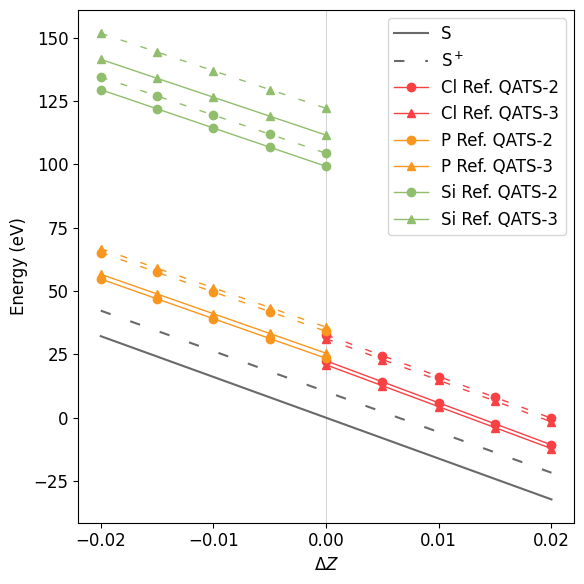

In [3]:
target_initial_charge = 0
delta_charge = 1
lambda_limits = (-1, 2)  # -1 to 2
yaxis_tick_spacing = 200
qats_step = 0.25
lambda_limits_plot = (-0.02, 0.02)



###   SCRIPT   ###

###   QA target initial   ###
qa_target_initial = df_qc.query(
    'n_electrons == @n_electrons'
    '& charge == @target_initial_charge'
    '& basis_set == @basis_set'
    '& @lambda_limits_plot[0] <= lambda_value & lambda_value <= @lambda_limits_plot[1]'
)
mult_target = get_multiplicity(qa_target_initial, excitation_level)
qa_target_initial = qa_target_initial.query('multiplicity == @mult_target')
qa_target_initial = qa_target_initial.query(
    '@lambda_limits[0] <= lambda_value & lambda_value <= @lambda_limits[1]'
)
lambda_sort = np.argsort(qa_target_initial['lambda_value'].values)

# Data
target_label = qa_target_initial.iloc[0]['system']
target_atomic_numbers = qa_target_initial.iloc[0]['atomic_numbers']
lambda_values = qa_target_initial['lambda_value'].values[lambda_sort]
qa_energies_target_initial = hartree_to_ev(qa_target_initial['electronic_energy'].values[lambda_sort])

target_idx_initial = np.where(lambda_values == 0)[0]
rel_e_ref = qa_energies_target_initial[target_idx_initial]
qa_energies_target_initial -= rel_e_ref

###   QATS initial   ###

qats_refs_initial = get_qa_refs(
    df_qc, df_qats, target_label, n_electrons, basis_set=basis_set,
    df_selection='qats', excitation_level=0,
    considered_lambdas=[i for i in range(min(lambda_limits), max(lambda_limits)+1)]
)
qats_initial = {}
qats_sys_labels = qats_refs_initial['system'].values
for ref_label in qats_sys_labels:
    qats_ref = qats_refs_initial.query('system == @ref_label')
    assert len(qats_ref) == 1
    ref_atomic_numbers = qats_ref.iloc[0]['atomic_numbers']
    ref_lambda_value = get_lambda_value(
        ref_atomic_numbers, target_atomic_numbers,
        specific_atom=specific_atom, direction=direction
    )
    # If ref_lambda_value = 1, we also want values from 1 to 0.98.
    # If ref_lambda_value = -1, we also want values from -1 to -0.98.
    bound_sign = (ref_lambda_value/(abs(ref_lambda_value)))
    lambda_bounds = (ref_lambda_value - 0.02*bound_sign, ref_lambda_value)
    
    qa_lambda_values = np.linspace(  # wrt reference
        min(lambda_bounds), max(lambda_bounds), endpoint=True, num=5
    )
    
    qats_energies = np.zeros((len(qats_orders), len(qa_lambda_values)))
    for i in range(len(qats_orders)):
        order = qats_orders[i]
        poly_coeffs = qats_ref.iloc[0]['poly_coeffs']
        qats_energies[i] = hartree_to_ev(qats_prediction(poly_coeffs, order, qa_lambda_values))
    qats_initial[ref_label] = {
        'energies': qats_energies - rel_e_ref,
        'lambda_values': qa_lambda_values - ref_lambda_value,  #wrt target
        'target_lambda_value': ref_lambda_value
    }
    





#####     FINAL     #####

###   QA target final  ###
qa_target_final = df_qc.query(
    'n_electrons == @n_electrons - @delta_charge'
    '& charge == @target_initial_charge + @delta_charge'
    '& basis_set == @basis_set'
    '& @lambda_limits_plot[0] <= lambda_value & lambda_value <= @lambda_limits_plot[1]'
)
mult_target = get_multiplicity(qa_target_final, excitation_level)
qa_target_final = qa_target_final.query('multiplicity == @mult_target')
lambda_sort = np.argsort(qa_target_final['lambda_value'].values)
assert np.array_equal(lambda_values, qa_target_final['lambda_value'].values[lambda_sort])

# Data
qa_energies_target_final = hartree_to_ev(qa_target_final['electronic_energy'].values[lambda_sort])
qa_energies_target_final -= rel_e_ref

target_idx_final = np.where(qa_target_final['lambda_value'].values[lambda_sort] == 0)[0]
target_e_final = qa_energies_target_final[target_idx_final]


###   QA final   ###

qats_refs_final = get_qa_refs(
    df_qc, df_qats, target_label, n_electrons-delta_charge, basis_set=basis_set,
    df_selection='qats', excitation_level=0,
    considered_lambdas=[i for i in range(min(lambda_limits), max(lambda_limits)+1)]
)
qats_final = {}
qats_sys_labels = qats_refs_final['system'].values
for ref_label in qats_sys_labels:
    qats_ref = qats_refs_final.query('system == @ref_label')
    assert len(qats_ref) == 1
    ref_atomic_numbers = qats_ref.iloc[0]['atomic_numbers']
    ref_lambda_value = get_lambda_value(
        ref_atomic_numbers, target_atomic_numbers,
        specific_atom=specific_atom, direction=direction
    )
    # If ref_lambda_value = 1, we also want values from 1 to 0.98.
    # If ref_lambda_value = -1, we also want values from -1 to -0.98.
    bound_sign = (ref_lambda_value/(abs(ref_lambda_value)))
    lambda_bounds = (ref_lambda_value - 0.02*bound_sign, ref_lambda_value)
    
    qa_lambda_values = np.linspace(  # wrt reference
        min(lambda_bounds), max(lambda_bounds), endpoint=True, num=5
    )
    
    qats_energies = np.zeros((len(qats_orders), len(qa_lambda_values)))
    for i in range(len(qats_orders)):
        order = qats_orders[i]
        poly_coeffs = qats_ref.iloc[0]['poly_coeffs']
        qats_energies[i] = hartree_to_ev(qats_prediction(poly_coeffs, order, qa_lambda_values))
    qats_final[ref_label] = {
        'energies': qats_energies - rel_e_ref,
        'lambda_values': qa_lambda_values - ref_lambda_value,  #wrt target
        'target_lambda_value': ref_lambda_value
    }




###   FIGURE   ###

fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')
qats_ref_colors = [
    '#F94144', '#F8961E', '#90BE6D', '#43AA8B', '#577590'
]
ref_shapes = ['o', '^', 's']
order_linestyles = ['solid', 'dashed', 'dotted']
ref_labels = list(qats_initial.keys())
ref_labels.sort()
ref_labels_plot = [i.capitalize() for i in ref_labels]
marker_size = 9
line_width = 2
target_label_plot = target_label.capitalize()


ax.plot (
    lambda_values, qa_energies_target_initial,
    color='dimgrey', linestyle='solid', label=f'{target_label_plot}'
)
ax.plot(
    lambda_values, qa_energies_target_final,
    color='dimgrey', linestyle=(0, (5, 10)), label=f'{target_label_plot}$^+$'
)

for i in range(len(ref_labels)):
    sys_label = ref_labels[i]
    lambda_values_wrt_target = qats_initial[sys_label]['lambda_values']
    energies = qats_initial[sys_label]['energies']
    for j in range(len(qats_orders)):
        order_energies = energies[j,:]
        ax.plot(
            lambda_values_wrt_target, order_energies,
            marker=ref_shapes[j],
            linestyle='solid', linewidth=1,
            color=qats_ref_colors[i], label=f'{ref_labels_plot[i]} Ref. QATS-{qats_orders[j]}'
        )

for i in range(len(ref_labels)):
    sys_label = ref_labels[i]
    lambda_values_wrt_target = qats_final[sys_label]['lambda_values']
    energies = qats_final[sys_label]['energies']
    for j in range(len(qats_orders)):
        order_energies = energies[j,:]
        ax.plot(
            lambda_values_wrt_target, order_energies,
            marker=ref_shapes[j],
            linestyle=(0, (5, 10)), linewidth=1,
            color=qats_ref_colors[i]
        )

        
ax.axvline(0, color='silver', zorder=0, linewidth=0.5)


# x ticks
ax.set_xlabel('$\Delta Z$')
ax.set_xticks(
    np.arange(min(lambda_limits_plot), max(lambda_limits_plot)+0.01, 0.01)
)

# y ticks
ax.set_ylabel('Energy (eV)')

ax.legend()

print()

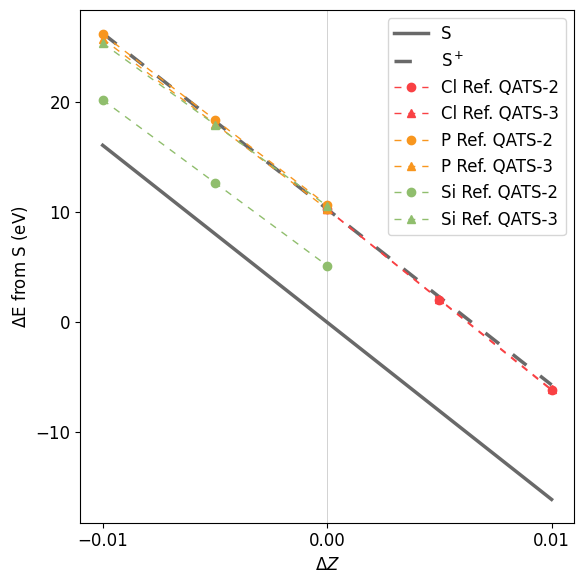

In [4]:
target_initial_charge = 0
delta_charge = 1
lambda_limits = (-1, 2)  # -1 to 2
yaxis_tick_spacing = 200
qats_step = 0.25
lambda_limits_plot = (-0.01, 0.01)
linspace_num = 3



###   SCRIPT   ###

###   QA target initial  ###
qa_target_initial = df_qc.query(
    'n_electrons == @n_electrons'
    '& charge == @target_initial_charge'
    '& basis_set == @basis_set'
    '& @lambda_limits_plot[0] <= lambda_value & lambda_value <= @lambda_limits_plot[1]'
)
mult_target = get_multiplicity(qa_target_initial, excitation_level)
qa_target_initial = qa_target_initial.query('multiplicity == @mult_target')
qa_target_initial = qa_target_initial.query(
    '@lambda_limits[0] <= lambda_value & lambda_value <= @lambda_limits[1]'
)
lambda_sort = np.argsort(qa_target_initial['lambda_value'].values)

# Data
target_label = qa_target_initial.iloc[0]['system']
target_atomic_numbers = qa_target_initial.iloc[0]['atomic_numbers']
lambda_values = qa_target_initial['lambda_value'].values[lambda_sort]
qa_energies_target_initial = hartree_to_ev(qa_target_initial['electronic_energy'].values[lambda_sort])

target_idx_initial = np.where(lambda_values == 0)[0]
rel_e_ref = qa_energies_target_initial[target_idx_initial]
qa_energies_target_initial -= rel_e_ref

###   QA target final  ###
qa_target_final = df_qc.query(
    'n_electrons == @n_electrons - @delta_charge'
    '& charge == @target_initial_charge + @delta_charge'
    '& basis_set == @basis_set'
    '& @lambda_limits_plot[0] <= lambda_value & lambda_value <= @lambda_limits_plot[1]'
)
mult_target = get_multiplicity(qa_target_final, excitation_level)
qa_target_final = qa_target_final.query('multiplicity == @mult_target')
lambda_sort = np.argsort(qa_target_final['lambda_value'].values)
assert np.array_equal(lambda_values, qa_target_final['lambda_value'].values[lambda_sort])

# Data
qa_energies_target_final = hartree_to_ev(qa_target_final['electronic_energy'].values[lambda_sort])
qa_energies_target_final -= rel_e_ref

target_idx_final = np.where(qa_target_final['lambda_value'].values[lambda_sort] == 0)[0]
target_e_final = qa_energies_target_final[target_idx_final]








###   QATS   ###

###   QATS initial   ###
qats_refs_initial = get_qa_refs(
    df_qc, df_qats, target_label, n_electrons, basis_set=basis_set,
    df_selection='qats', excitation_level=0,
    considered_lambdas=[i for i in range(min(lambda_limits), max(lambda_limits)+1)]
)
qats_initial = {}
qats_sys_labels = qats_refs_initial['system'].values
for ref_label in qats_sys_labels:
    qats_ref = qats_refs_initial.query('system == @ref_label')
    assert len(qats_ref) == 1
    ref_atomic_numbers = qats_ref.iloc[0]['atomic_numbers']
    ref_lambda_value = get_lambda_value(
        ref_atomic_numbers, target_atomic_numbers,
        specific_atom=specific_atom, direction=direction
    )
    # If ref_lambda_value = 1, we also want values from 1 to 0.98.
    # If ref_lambda_value = -1, we also want values from -1 to -0.98.
    bound_sign = (ref_lambda_value/(abs(ref_lambda_value)))
    lambda_bounds = (ref_lambda_value - lambda_limits_plot[1]*bound_sign, ref_lambda_value)
    
    qa_lambda_values = np.linspace(  # wrt reference
        min(lambda_bounds), max(lambda_bounds), endpoint=True, num=linspace_num
    )
    lambda_values_wrt_target = qa_lambda_values - ref_lambda_value
    
    qats_energies = np.zeros((len(qats_orders), len(qa_lambda_values)))
    qats_target = np.zeros((len(qats_orders),))
    for i in range(len(qats_orders)):
        order = qats_orders[i]
        poly_coeffs = qats_ref.iloc[0]['poly_coeffs']
        qats_energies[i] = hartree_to_ev(
            qats_prediction(poly_coeffs, order, qa_lambda_values)
        )
        qats_energies[i] -= rel_e_ref
        
    qats_initial[ref_label] = {
        'energies': qats_energies,
        'lambda_values_wrt_target': lambda_values_wrt_target,
        'target_lambda_value': ref_lambda_value,
    }




###   QATS final   ###

qats_refs_final = get_qa_refs(
    df_qc, df_qats, target_label, n_electrons-delta_charge, basis_set=basis_set,
    df_selection='qats', excitation_level=0,
    considered_lambdas=[i for i in range(min(lambda_limits), max(lambda_limits)+1)]
)
qats_final = {}
qats_sys_labels = qats_refs_final['system'].values
for ref_label in qats_sys_labels:
    qats_ref = qats_refs_final.query('system == @ref_label')
    assert len(qats_ref) == 1
    ref_atomic_numbers = qats_ref.iloc[0]['atomic_numbers']
    ref_lambda_value = get_lambda_value(
        ref_atomic_numbers, target_atomic_numbers,
        specific_atom=specific_atom, direction=direction
    )
    # If ref_lambda_value = 1, we also want values from 1 to 0.98.
    # If ref_lambda_value = -1, we also want values from -1 to -0.98.
    bound_sign = (ref_lambda_value/(abs(ref_lambda_value)))
    lambda_bounds = (ref_lambda_value - lambda_limits_plot[1]*bound_sign, ref_lambda_value)
    
    qa_lambda_values = np.linspace(  # wrt reference
        min(lambda_bounds), max(lambda_bounds), endpoint=True, num=linspace_num
    )
    lambda_values_wrt_target = qa_lambda_values - ref_lambda_value
    
    qats_energies = np.zeros((len(qats_orders), len(qa_lambda_values)))
    for i in range(len(qats_orders)):
        energies_neutral = qats_initial[ref_label]['energies'][i]
        target_idx = np.where(
            qats_initial[ref_label]['lambda_values_wrt_target'] == 0
        )[0]
        e_shift = energies_neutral[target_idx]
    
        order = qats_orders[i]
        poly_coeffs = qats_ref.iloc[0]['poly_coeffs']
        qats_energies[i] = hartree_to_ev(qats_prediction(poly_coeffs, order, qa_lambda_values))
        qats_energies[i] -= rel_e_ref + e_shift
        
        
    qats_final[ref_label] = {
        'energies': qats_energies,
        'lambda_values_wrt_target': lambda_values_wrt_target,
        'target_lambda_value': ref_lambda_value
    }




###   FIGURE   ###

fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')
qats_ref_colors = [
    '#F94144', '#F8961E', '#90BE6D', '#43AA8B', '#577590'
]
ref_shapes = ['o', '^', 's']
order_linestyles = ['solid', 'dashed', 'dotted']
ref_labels = list(qats_initial.keys())
ref_labels.sort()
ref_labels_plot = [i.capitalize() for i in ref_labels]
marker_size = 10
line_width = 2.5
dotted_linesytle = (0, (5, 5))
target_label_plot = target_label.capitalize()


ax.plot (
    lambda_values, qa_energies_target_initial, linewidth=line_width,
    color='dimgrey', linestyle='solid', label=f'{target_label_plot}'
)
ax.plot(
    lambda_values, qa_energies_target_final, linewidth=line_width,
    color='dimgrey', linestyle=dotted_linesytle, label=f'{target_label_plot}$^+$'
)

for i in range(len(ref_labels)):
    sys_label = ref_labels[i]
    lambda_values_wrt_target = qats_final[sys_label]['lambda_values_wrt_target']
    energies = qats_final[sys_label]['energies']
    for j in range(len(qats_orders)):
        order_energies = energies[j,:]
        ax.plot(
            lambda_values_wrt_target, order_energies,
            marker=ref_shapes[j],
            linestyle=dotted_linesytle, linewidth=1,
            color=qats_ref_colors[i], label=f'{ref_labels_plot[i]} Ref. QATS-{qats_orders[j]}'
        )

        
ax.axvline(0, color='silver', zorder=0, linewidth=0.5)


# x ticks
ax.set_xlabel('$\Delta Z$')
ax.set_xticks(
    np.arange(min(lambda_limits_plot), max(lambda_limits_plot)+0.01, 0.01)
)

# y ticks
ax.set_ylabel(f'$\Delta$E from {target_label_plot} (eV)')

ax.legend()

print()